No. counties (covid df): 3195 
No. counties (county df): 3220 
No. counties (merged df): 3140 



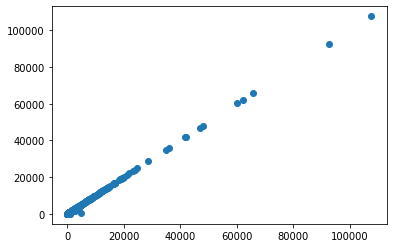

In [31]:
"""
DATA SOURCES:
https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/
https://www.kaggle.com/muonneutrino/us-census-demographic-data?select=acs2015_county_data.csv
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


data_dir=r'C:\Users\Cafral\Desktop\kaggle\team_ts_forecast\embeddings\data'

#loading the data

#county data
county_data = pd.read_csv(data_dir+r'\county_data\datasets_7001_312628_acs2015_county_data.csv')

#covid num cases data
covid_data = pd.read_csv(data_dir+r'\covid_data\covid_confirmed_usafacts.csv')
covid_data.drop(columns=['County Name','State','stateFIPS'],inplace=True)
covid_data['max_case_count']= covid_data[covid_data.columns[1:]].max(axis=1)

#cumulative reporting
plt.scatter(covid_data['max_case_count'],covid_data['7/5/20'])
plt.plot()

merged_data = pd.merge(county_data,covid_data[['countyFIPS','max_case_count']],
                       left_on=['CensusId']
                       ,right_on=['countyFIPS'])
merged_data.drop(columns=['countyFIPS'],inplace=True)

merged_data.dropna(inplace=True)
#disparity in num of counties
print('No. counties (covid df):',covid_data.shape[0],'\n'
      'No. counties (county df):',county_data.shape[0],'\n'
      'No. counties (merged df):',merged_data.shape[0],'\n'
     )

#keeping only relevant data
relevant_cols = ['TotalPop', 'Men', 'Women', 'Hispanic',
                 'White', 'Black', 'Native', 'Asian', 'Pacific',
                 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
                 'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
                 'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
                 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
                 'SelfEmployed', 'FamilyWork', 'Unemployment']#could add state here too?

#len(relevant_cols)

target_var = ['max_case_count']

train_df =merged_data[relevant_cols+target_var]

# Data Prep

In [2]:
label_encoders = {}

for cat_col in relevant_cols:
        label_encoders[cat_col] = LabelEncoder()
        train_df[cat_col] = label_encoders[cat_col].fit_transform(train_df[cat_col])

C:\Users\Cafral\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
#training data for visualization
train_df_viz = train_df.merge(merged_data[['State','County']],left_on=[train_df.index],
                                       right_on=[merged_data.index])

train_df_viz =train_df_viz[train_df_viz.columns[1:]]

# Model

In [5]:
"""
based on :

https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
"""

class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]


class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)

    x = self.output_layer(x)

    return x

In [7]:
dataset = TabularDataset(data=train_df, cat_cols=relevant_cols,output_col=target_var)

batchsize = 200 #10
dataloader = DataLoader(dataset, batchsize, shuffle=True,)

cat_dims = [int(train_df[col].nunique()) for col in relevant_cols]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

model = FeedForwardNN(emb_dims, no_of_cont=0, lin_layer_sizes=[50, 100],
                          output_size=1, emb_dropout=0,#0.04,
                          lin_layer_dropouts=[0.001,0.01])

#training the model
torch.manual_seed(0)
np.random.seed(0)

no_of_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(no_of_epochs):
    for y,cont_x, cat_x in dataloader:

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print(loss.item())
        loss_item = loss.item() / len(train_df) 
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, no_of_epochs, loss_item))       

epoch : 1/1000, loss = 6696.524841
epoch : 2/1000, loss = 3454.474204
epoch : 3/1000, loss = 6547.149045
epoch : 4/1000, loss = 3707.544904
epoch : 5/1000, loss = 3091.594586
epoch : 6/1000, loss = 885.334713
epoch : 7/1000, loss = 168.087560
epoch : 8/1000, loss = 7367.645223
epoch : 9/1000, loss = 545.483400
epoch : 10/1000, loss = 5374.460510
epoch : 11/1000, loss = 574.350597
epoch : 12/1000, loss = 1973.527866
epoch : 13/1000, loss = 154.988804
epoch : 14/1000, loss = 92.406986
epoch : 15/1000, loss = 319.446815
epoch : 16/1000, loss = 282.471218
epoch : 17/1000, loss = 6493.943312
epoch : 18/1000, loss = 414.731330
epoch : 19/1000, loss = 4129.269108
epoch : 20/1000, loss = 1958.977866
epoch : 21/1000, loss = 1686.838694
epoch : 22/1000, loss = 170.924403
epoch : 23/1000, loss = 13980.171975
epoch : 24/1000, loss = 2930.000000
epoch : 25/1000, loss = 240.565247
epoch : 26/1000, loss = 376.037460
epoch : 27/1000, loss = 514.664490
epoch : 28/1000, loss = 240.126294
epoch : 29/1000

epoch : 234/1000, loss = 268.538018
epoch : 235/1000, loss = 241.567377
epoch : 236/1000, loss = 30.386848
epoch : 237/1000, loss = 74.838152
epoch : 238/1000, loss = 82.317178
epoch : 239/1000, loss = 521.269467
epoch : 240/1000, loss = 36.594198
epoch : 241/1000, loss = 68.341053
epoch : 242/1000, loss = 21.893551
epoch : 243/1000, loss = 35.652896
epoch : 244/1000, loss = 46.617814
epoch : 245/1000, loss = 72.303787
epoch : 246/1000, loss = 27.412035
epoch : 247/1000, loss = 56.194631
epoch : 248/1000, loss = 135.628374
epoch : 249/1000, loss = 27.274562
epoch : 250/1000, loss = 17.335529
epoch : 251/1000, loss = 37.075443
epoch : 252/1000, loss = 32.210793
epoch : 253/1000, loss = 35.933240
epoch : 254/1000, loss = 52.356887
epoch : 255/1000, loss = 22.785261
epoch : 256/1000, loss = 82.268745
epoch : 257/1000, loss = 141.525776
epoch : 258/1000, loss = 34.873005
epoch : 259/1000, loss = 180.766879
epoch : 260/1000, loss = 32.898064
epoch : 261/1000, loss = 54.084465
epoch : 262/10

epoch : 467/1000, loss = 37.930732
epoch : 468/1000, loss = 98.117227
epoch : 469/1000, loss = 57.655091
epoch : 470/1000, loss = 34.458372
epoch : 471/1000, loss = 29.111709
epoch : 472/1000, loss = 13.838995
epoch : 473/1000, loss = 32.646395
epoch : 474/1000, loss = 52.535032
epoch : 475/1000, loss = 20.673787
epoch : 476/1000, loss = 37.541135
epoch : 477/1000, loss = 98.239162
epoch : 478/1000, loss = 102.123577
epoch : 479/1000, loss = 62.394536
epoch : 480/1000, loss = 40.106265
epoch : 481/1000, loss = 33.362828
epoch : 482/1000, loss = 42.691317
epoch : 483/1000, loss = 66.115729
epoch : 484/1000, loss = 62.977065
epoch : 485/1000, loss = 35.697497
epoch : 486/1000, loss = 19.454890
epoch : 487/1000, loss = 52.414072
epoch : 488/1000, loss = 29.515150
epoch : 489/1000, loss = 88.156031
epoch : 490/1000, loss = 34.412381
epoch : 491/1000, loss = 80.381011
epoch : 492/1000, loss = 156.627389
epoch : 493/1000, loss = 93.252418
epoch : 494/1000, loss = 31.590217
epoch : 495/1000, 

epoch : 700/1000, loss = 32.619586
epoch : 701/1000, loss = 24.229528
epoch : 702/1000, loss = 76.960510
epoch : 703/1000, loss = 42.374985
epoch : 704/1000, loss = 58.115406
epoch : 705/1000, loss = 97.512600
epoch : 706/1000, loss = 128.380135
epoch : 707/1000, loss = 40.983940
epoch : 708/1000, loss = 26.957964
epoch : 709/1000, loss = 99.470313
epoch : 710/1000, loss = 63.499896
epoch : 711/1000, loss = 23.295524
epoch : 712/1000, loss = 75.015307
epoch : 713/1000, loss = 28.555775
epoch : 714/1000, loss = 41.632599
epoch : 715/1000, loss = 34.539717
epoch : 716/1000, loss = 52.411470
epoch : 717/1000, loss = 39.420263
epoch : 718/1000, loss = 21.720813
epoch : 719/1000, loss = 24.719481
epoch : 720/1000, loss = 81.347223
epoch : 721/1000, loss = 43.726627
epoch : 722/1000, loss = 10.398516
epoch : 723/1000, loss = 95.282215
epoch : 724/1000, loss = 94.354827
epoch : 725/1000, loss = 434.405255
epoch : 726/1000, loss = 21.074375
epoch : 727/1000, loss = 15.985746
epoch : 728/1000, 

epoch : 934/1000, loss = 55.262226
epoch : 935/1000, loss = 63.752926
epoch : 936/1000, loss = 35.754735
epoch : 937/1000, loss = 22.156807
epoch : 938/1000, loss = 38.760850
epoch : 939/1000, loss = 44.332638
epoch : 940/1000, loss = 719.240924
epoch : 941/1000, loss = 84.327398
epoch : 942/1000, loss = 19.648822
epoch : 943/1000, loss = 14.685868
epoch : 944/1000, loss = 38.323990
epoch : 945/1000, loss = 39.820954
epoch : 946/1000, loss = 30.812144
epoch : 947/1000, loss = 8.577824
epoch : 948/1000, loss = 37.242608
epoch : 949/1000, loss = 22.439192
epoch : 950/1000, loss = 11.372371
epoch : 951/1000, loss = 290.468670
epoch : 952/1000, loss = 66.153045
epoch : 953/1000, loss = 58.722820
epoch : 954/1000, loss = 62.267795
epoch : 955/1000, loss = 26.885933
epoch : 956/1000, loss = 16.593796
epoch : 957/1000, loss = 87.649672
epoch : 958/1000, loss = 484.060908
epoch : 959/1000, loss = 121.998189
epoch : 960/1000, loss = 6.860570
epoch : 961/1000, loss = 39.087711
epoch : 962/1000, 

In [8]:
# looking at the model structure
model.eval() #gives one embedding per feature

"""
for name, param in model.named_parameters():
    print(name,param.shape)
"""

FeedForwardNN(
  (emb_layers): ModuleList(
    (0): Embedding(3087, 50)
    (1): Embedding(3021, 50)
    (2): Embedding(3032, 50)
    (3): Embedding(447, 50)
    (4): Embedding(703, 50)
    (5): Embedding(487, 50)
    (6): Embedding(182, 50)
    (7): Embedding(130, 50)
    (8): Embedding(26, 13)
    (9): Embedding(2987, 50)
    (10): Embedding(2282, 50)
    (11): Embedding(2883, 50)
    (12): Embedding(1745, 50)
    (13): Embedding(333, 50)
    (14): Embedding(494, 50)
    (15): Embedding(343, 50)
    (16): Embedding(226, 50)
    (17): Embedding(190, 50)
    (18): Embedding(236, 50)
    (19): Embedding(291, 50)
    (20): Embedding(357, 50)
    (21): Embedding(185, 50)
    (22): Embedding(117, 50)
    (23): Embedding(168, 50)
    (24): Embedding(89, 45)
    (25): Embedding(187, 50)
    (26): Embedding(304, 50)
    (27): Embedding(3025, 50)
    (28): Embedding(374, 50)
    (29): Embedding(315, 50)
    (30): Embedding(219, 50)
    (31): Embedding(39, 20)
    (32): Embedding(202, 50)
  )
 

C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
C:\Users\Cafral\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1089: UserWarning: You are merging on int and float columns where the float

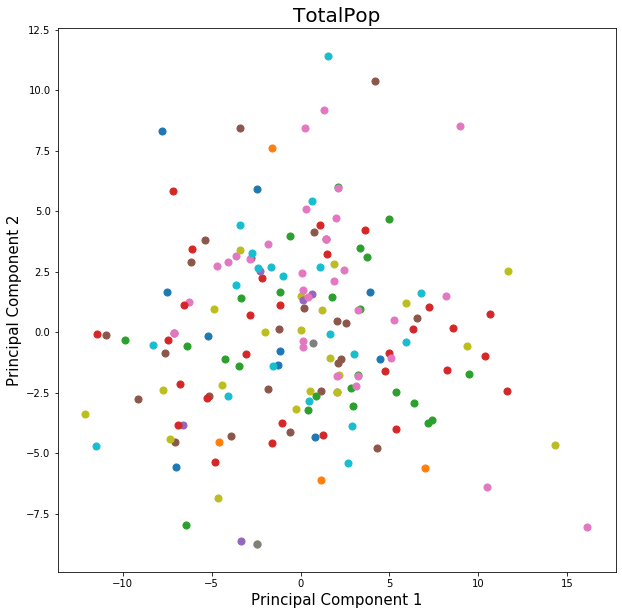

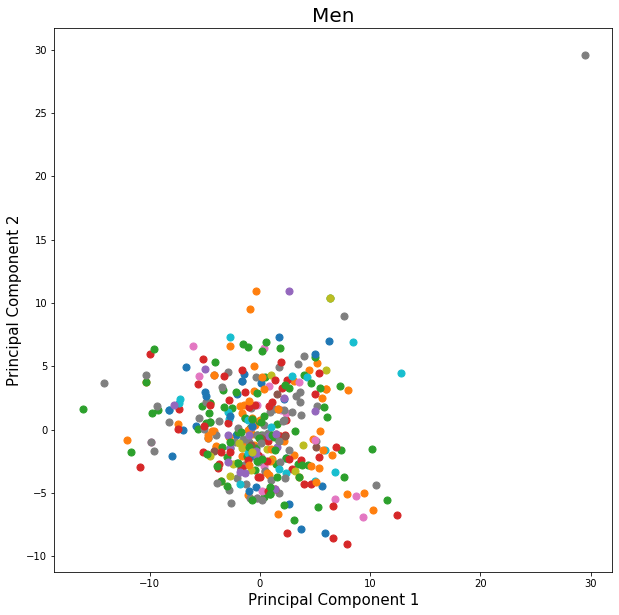

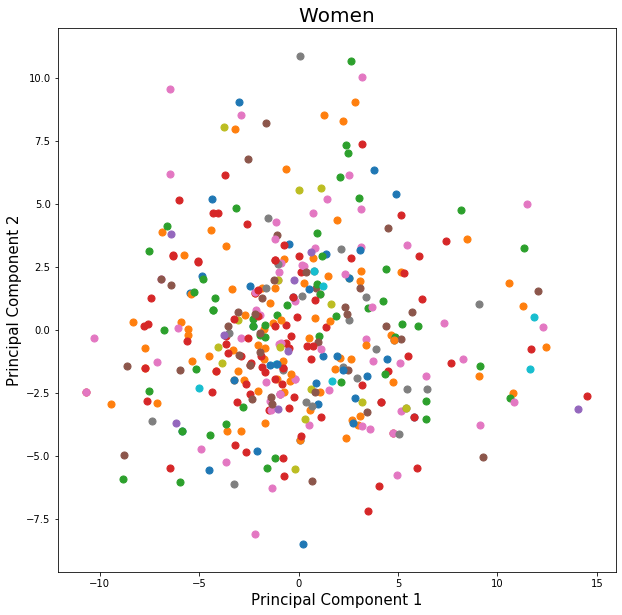

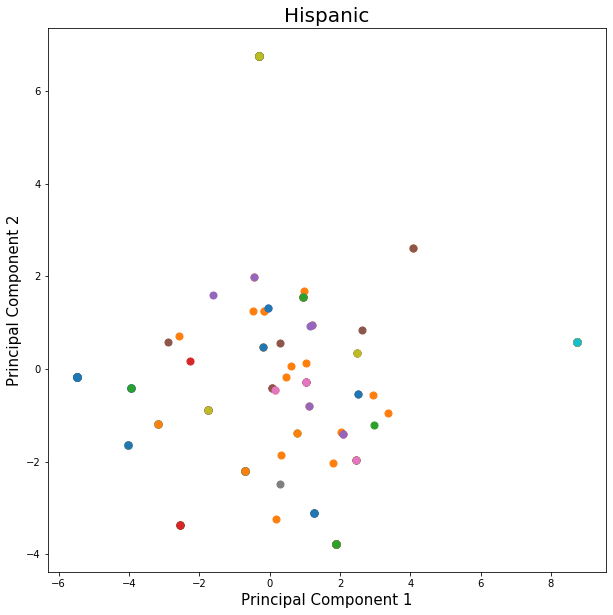

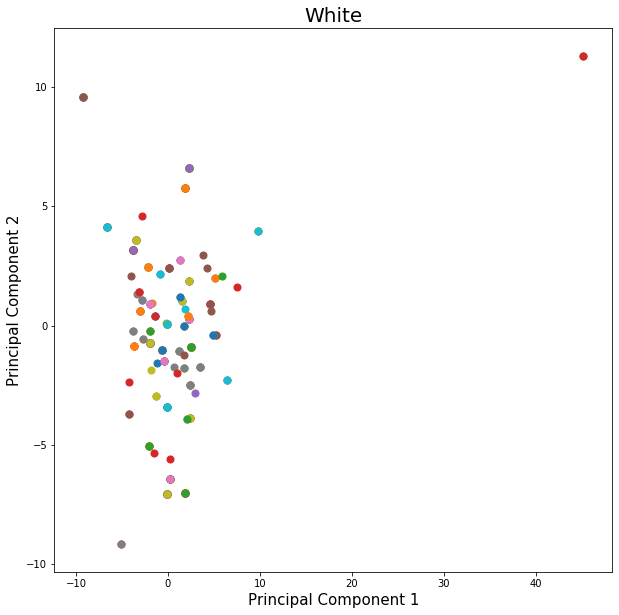

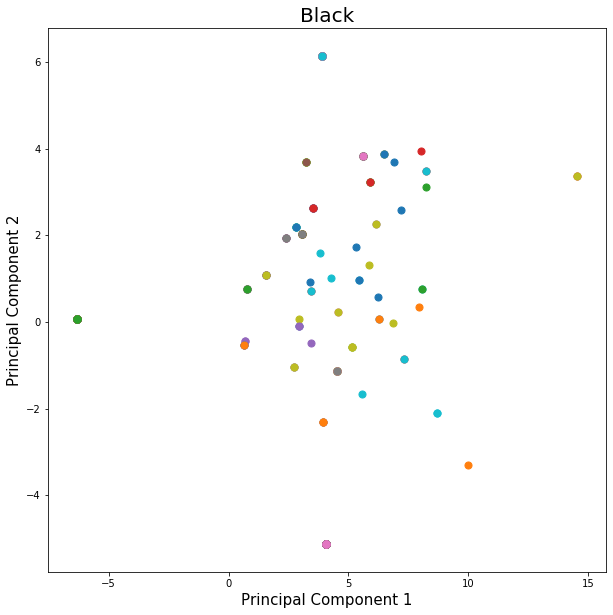

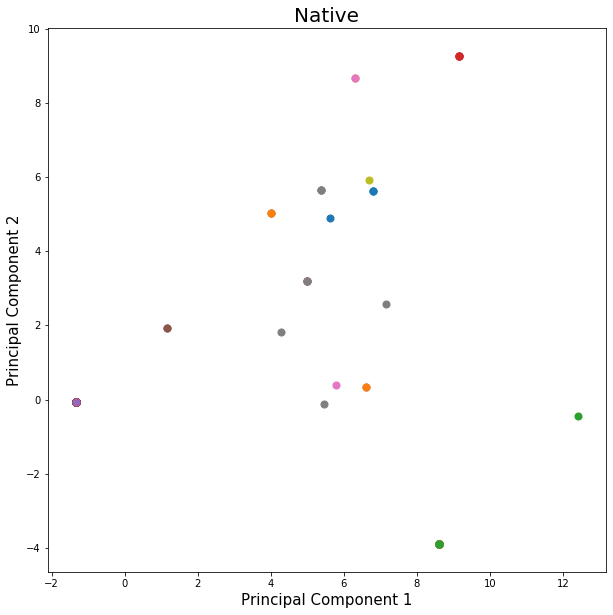

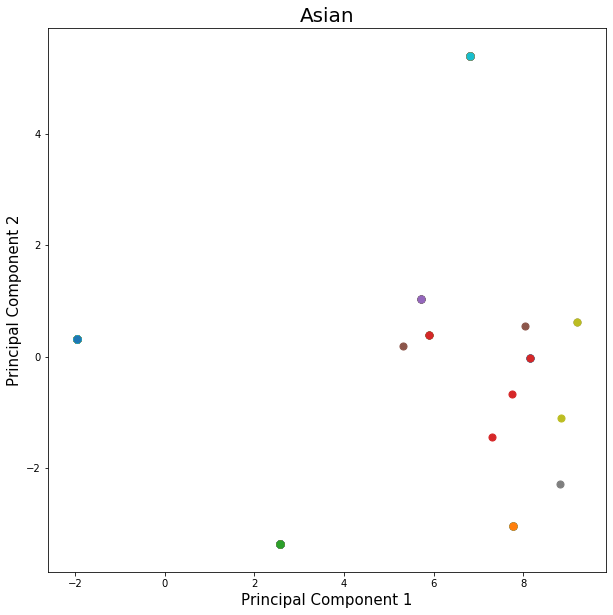

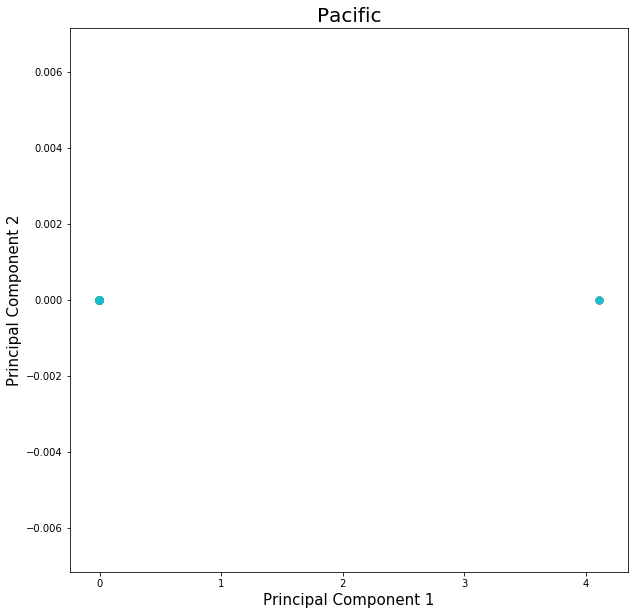

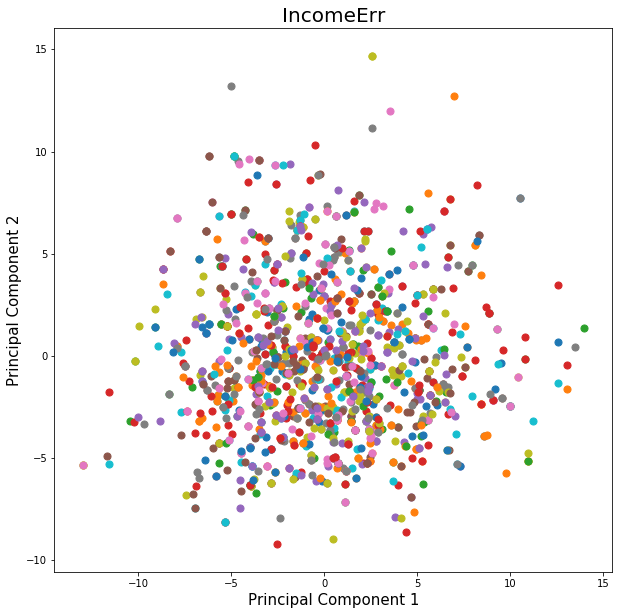

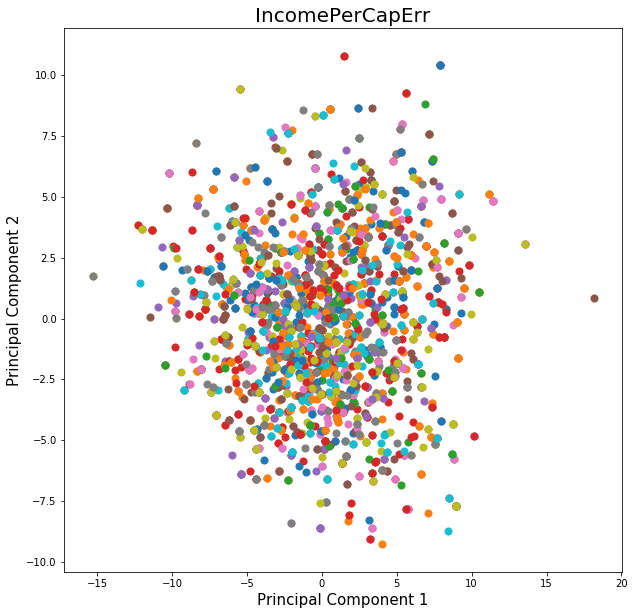

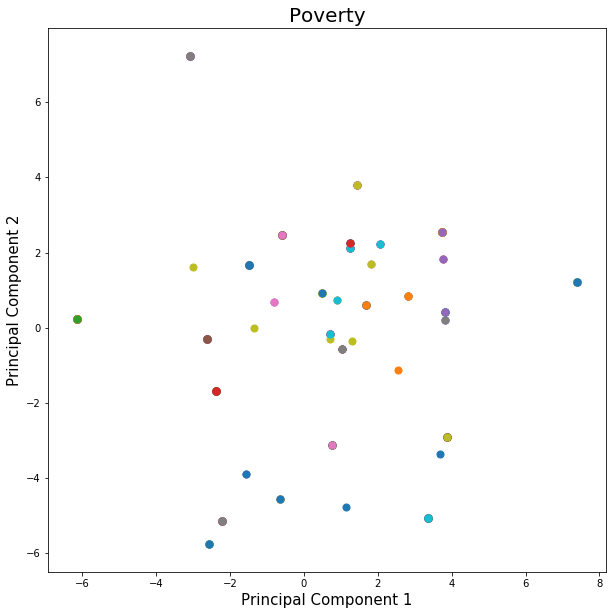

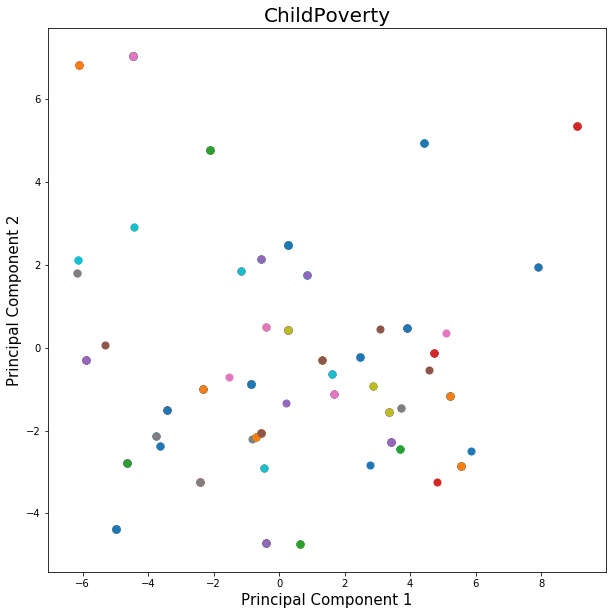

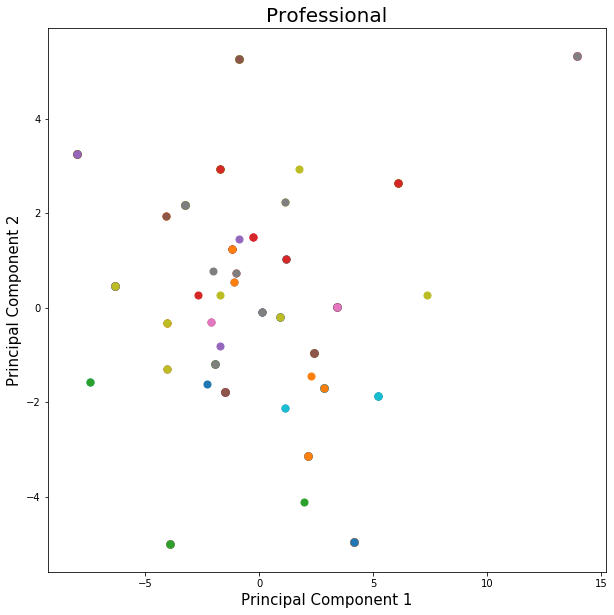

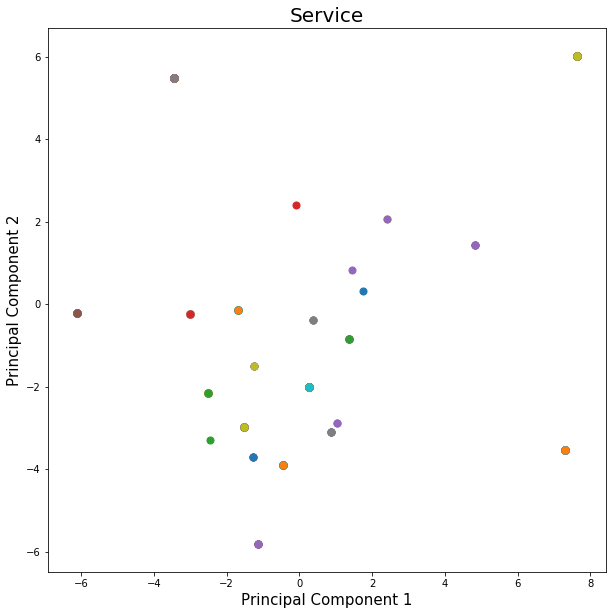

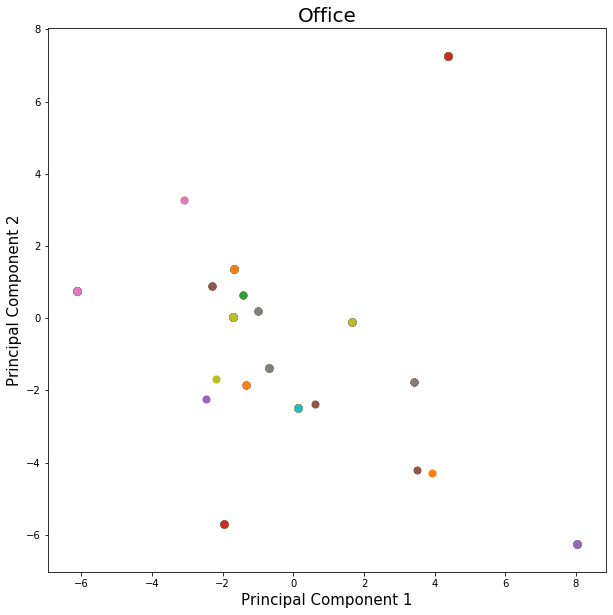

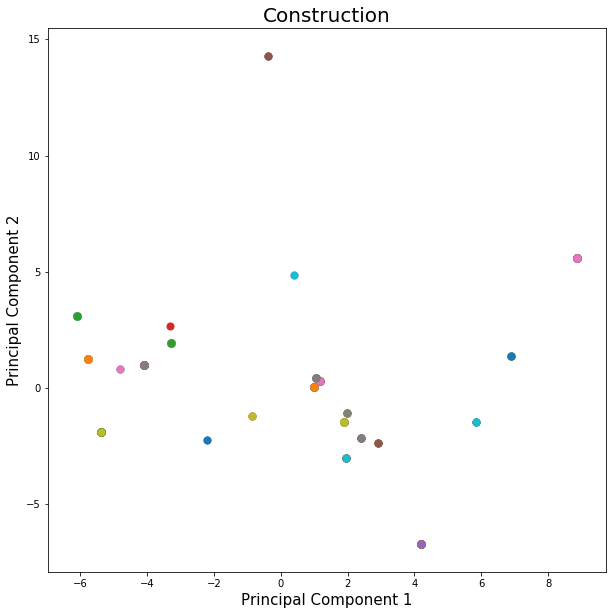

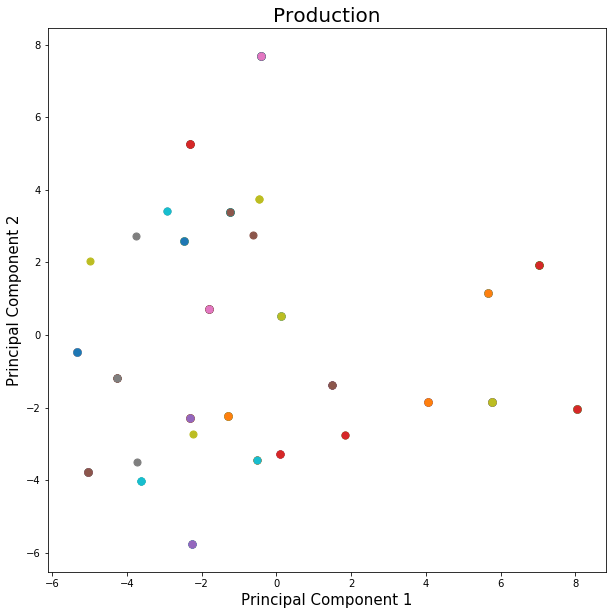

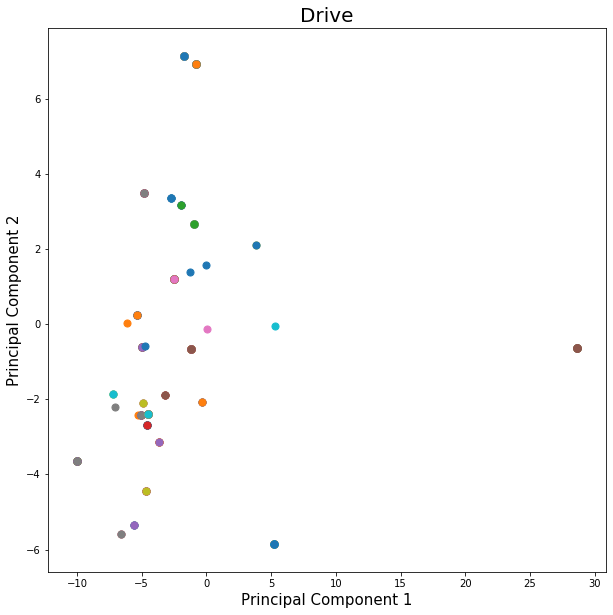

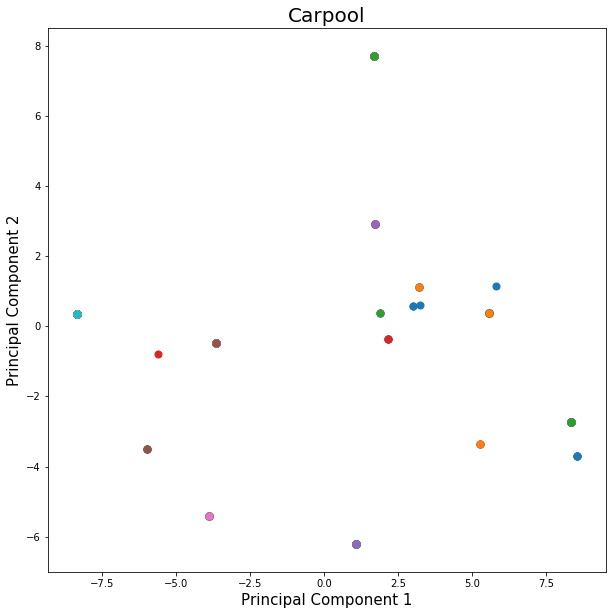

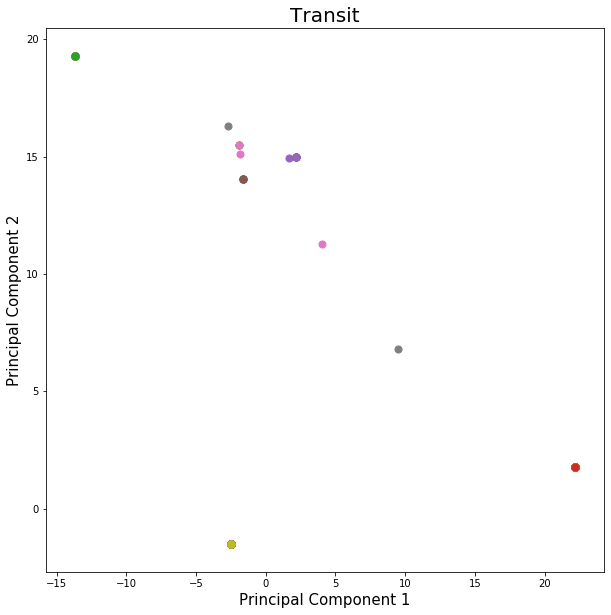

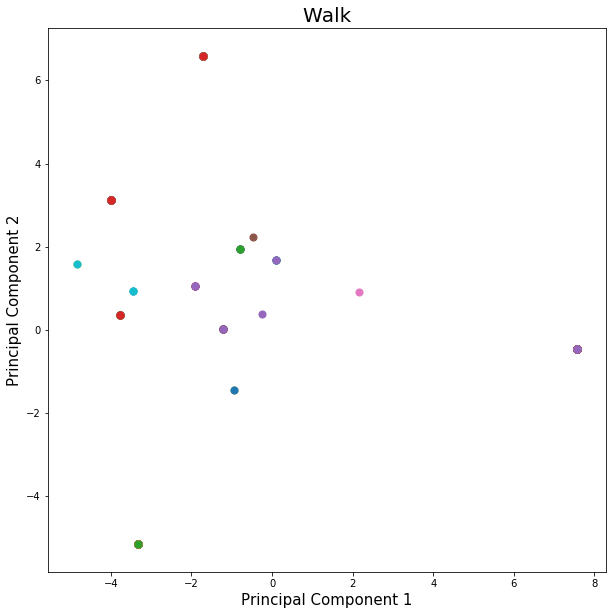

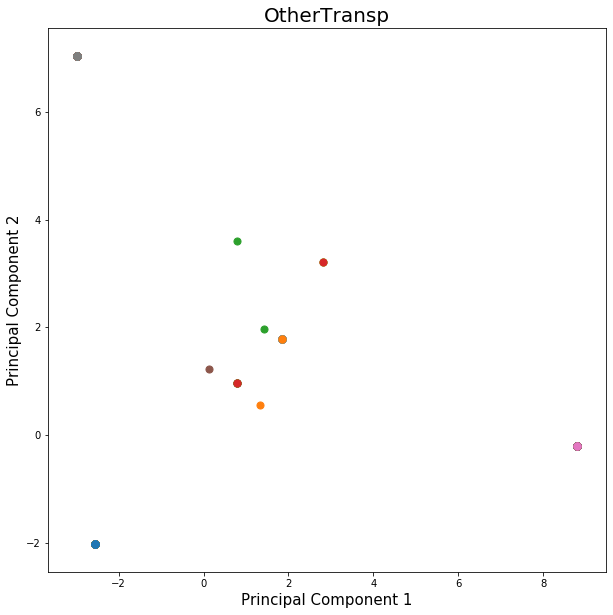

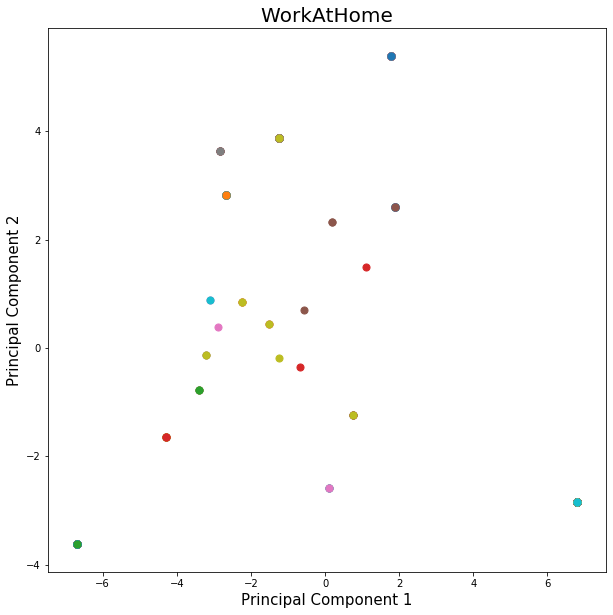

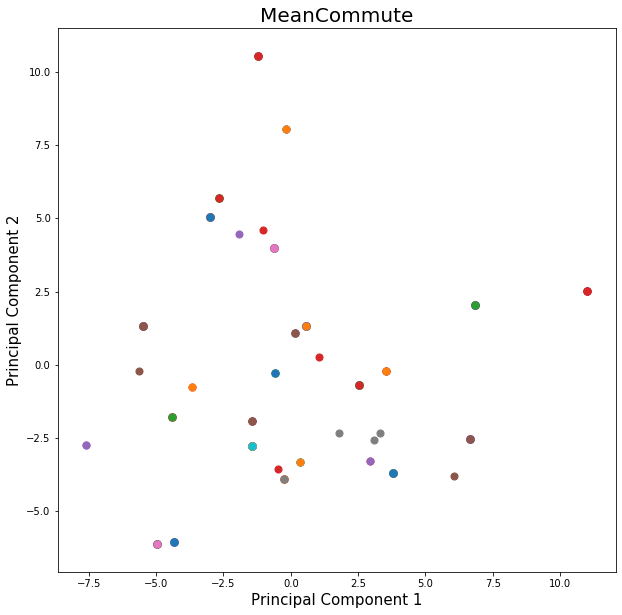

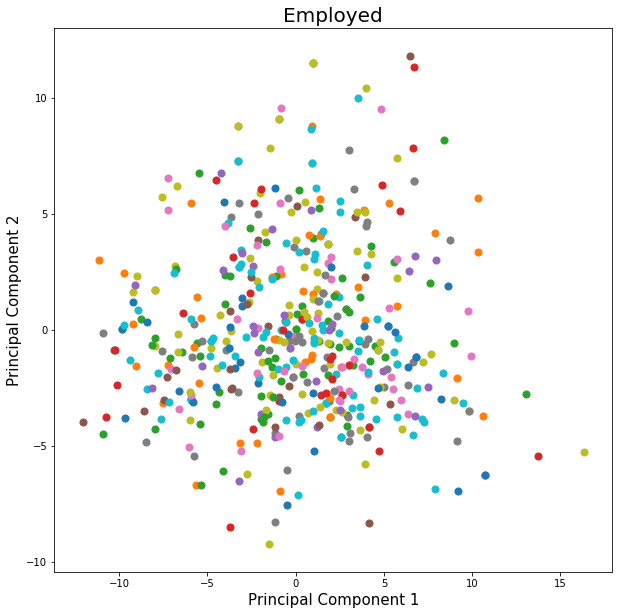

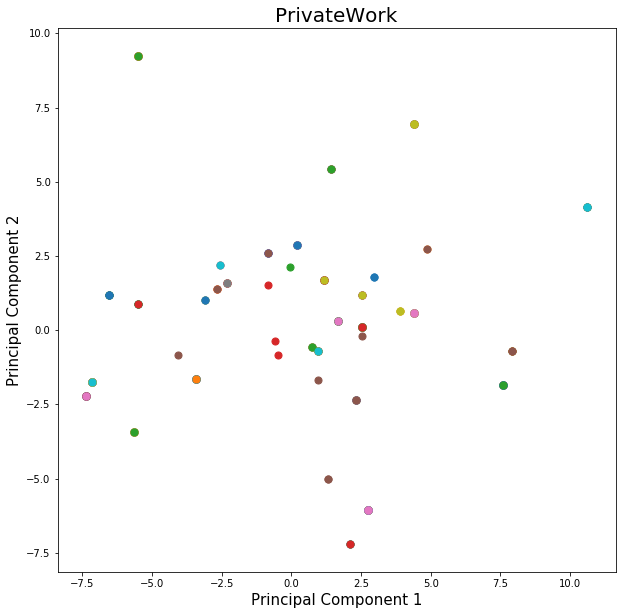

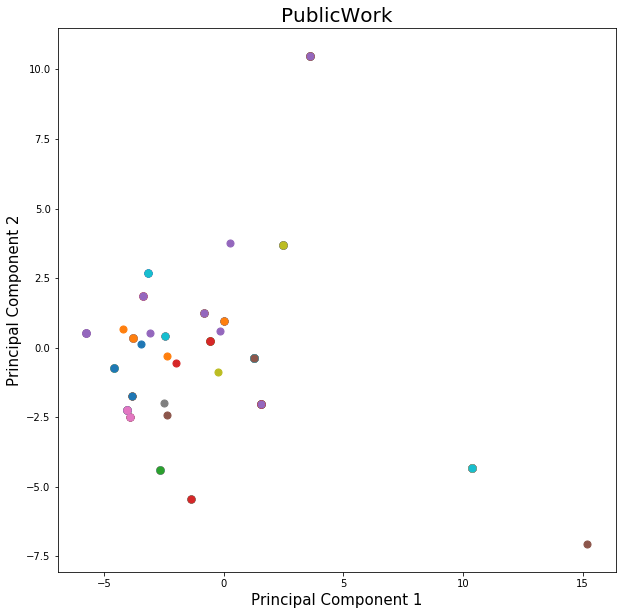

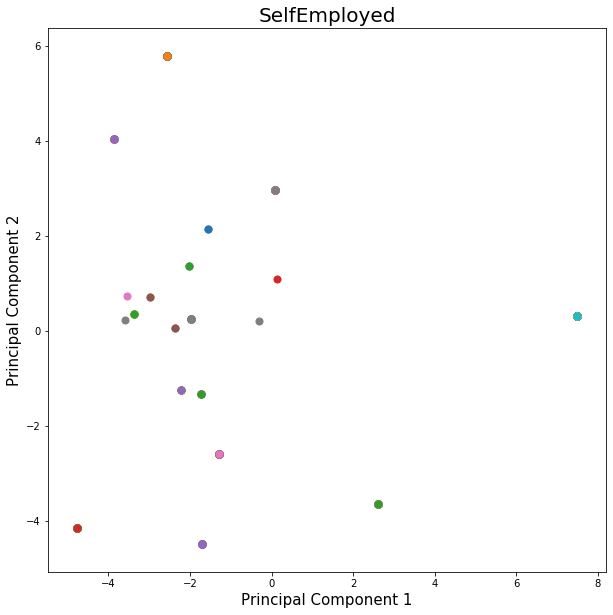

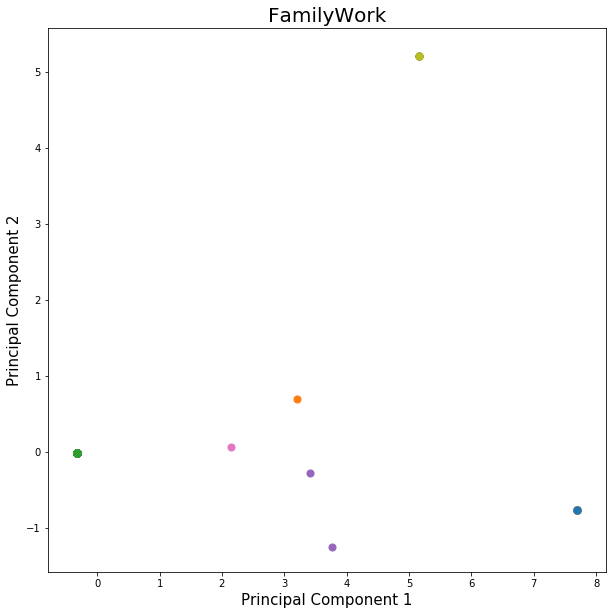

In [10]:
#PLOTTING EACH FEATURE
for layer_num,col_name in zip(range(0,32),relevant_cols):
    try:
        df = pd.DataFrame([tensor_row.detach().numpy() for tensor_row in model.emb_layers[layer_num].weight])
        map_to_county = pd.merge(merged_data[['State','County',col_name]],df,left_on=col_name,right_on=df.index)
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(map_to_county[map_to_county.columns[3:]])

        map_to_county['comp1'] = principalComponents[:,0]
        map_to_county['comp2'] = principalComponents[:,1]

        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title(col_name, fontsize = 20)

        for state in map_to_county['State'].unique():
            finalDf = map_to_county[map_to_county['State'] == state]
            ax.scatter(finalDf['comp1'],finalDf['comp2'], s = 50)
    except:
        pass
    

In [14]:
#MERGING EMBEDDINGS TOGETHER

base_data = train_df_viz[['State','County']]
for layer_num,col_name in zip(range(0,32),relevant_cols):
    df = pd.DataFrame([tensor_row.detach().numpy() for tensor_row in model.emb_layers[layer_num].weight])    
    map_to_county = pd.merge(train_df_viz[['State','County',col_name]],
                             df,left_on=col_name,right_on=df.index)
    if len(map_to_county)>0:
        base_data = base_data.merge(map_to_county,on=['State','County'])
    else:
        pass
base_data.drop(columns=['TotalPop'],inplace=True)

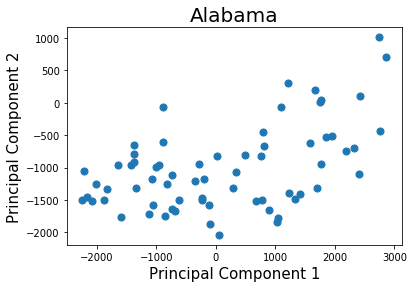

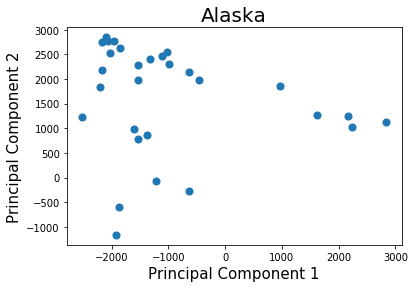

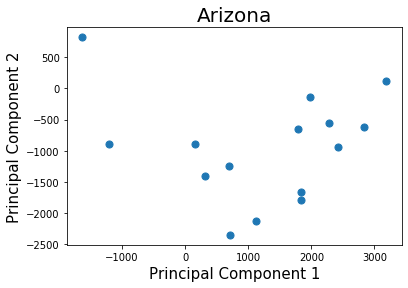

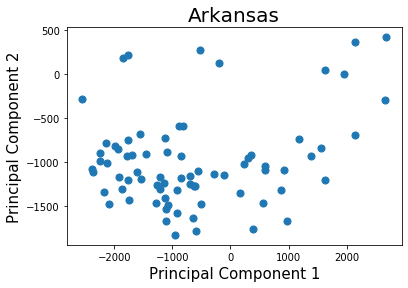

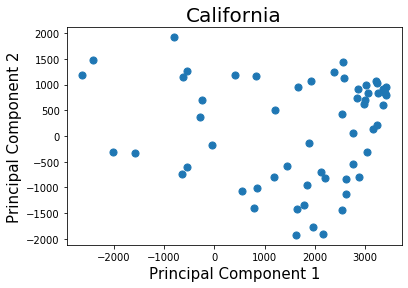

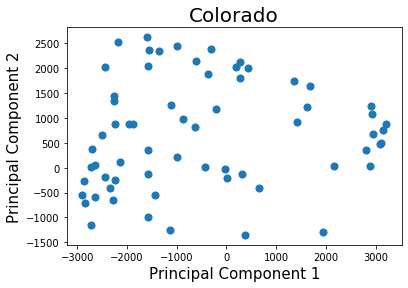

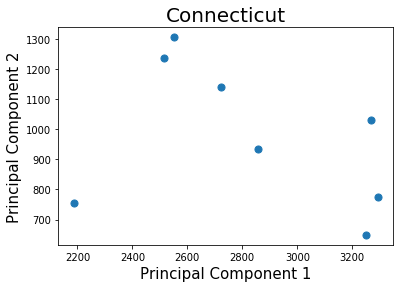

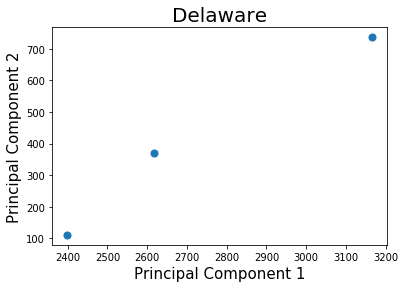

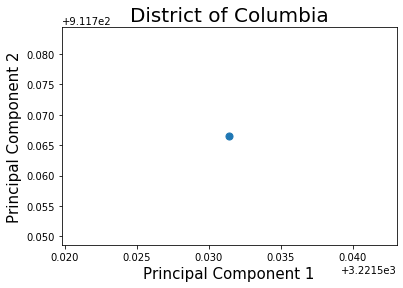

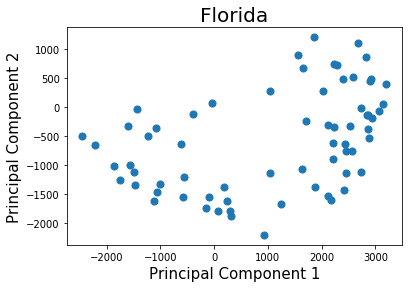

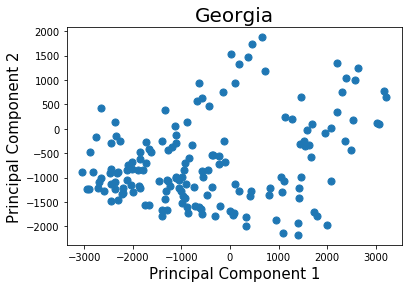

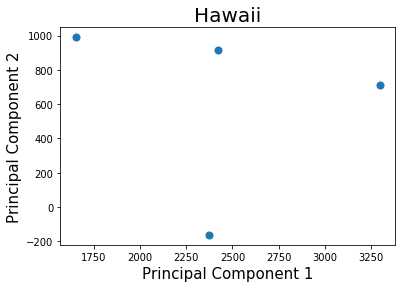

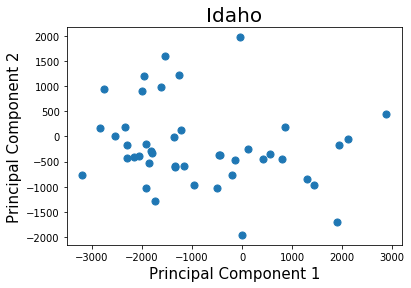

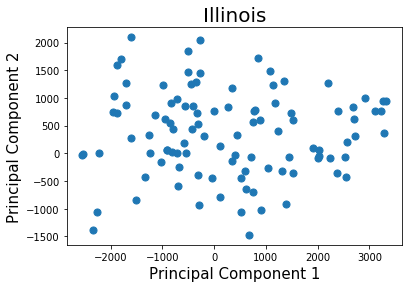

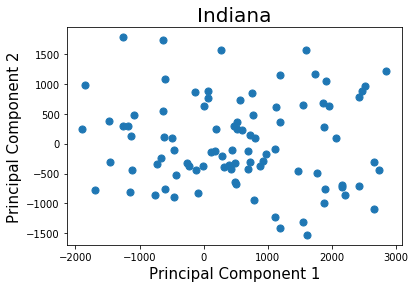

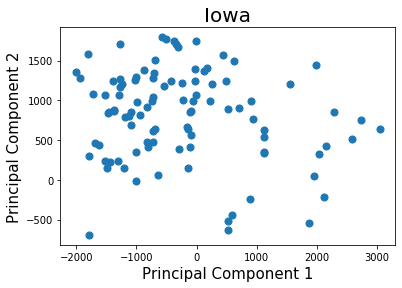

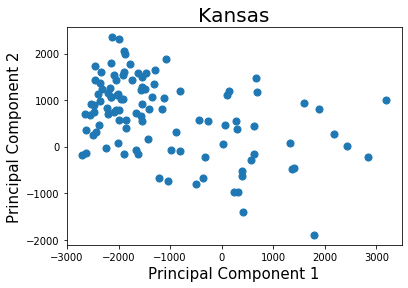

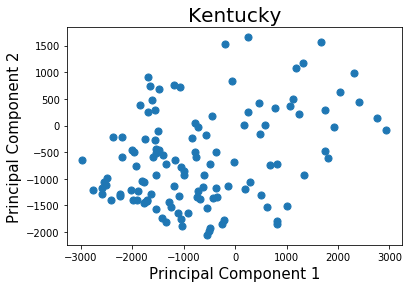

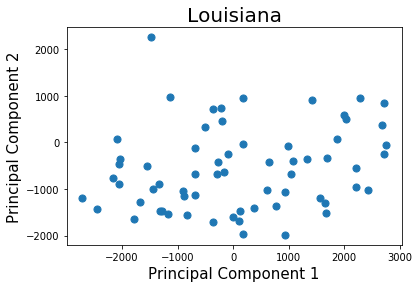

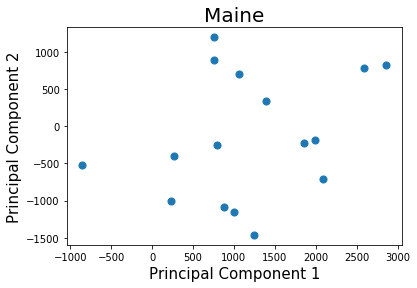

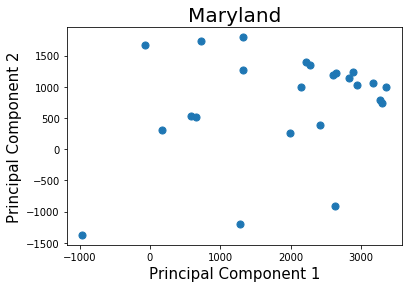

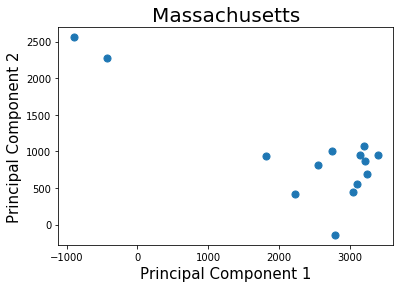

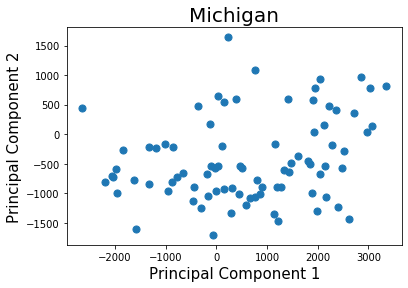

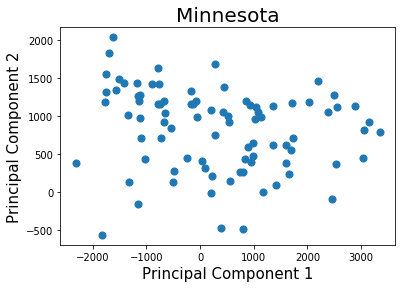

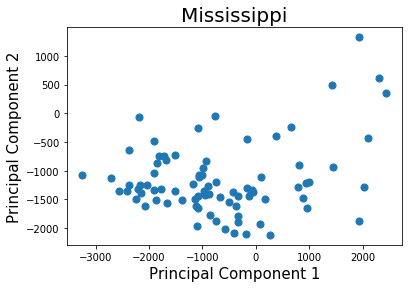

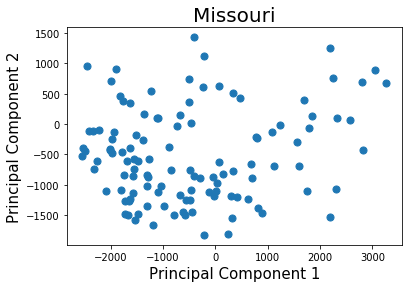

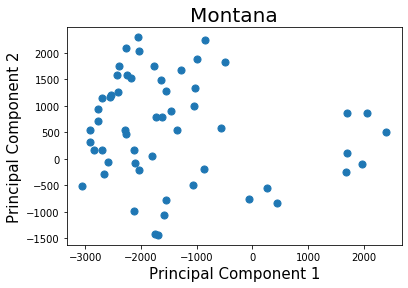

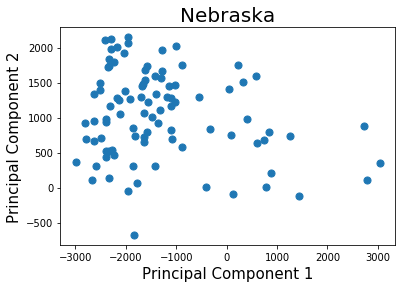

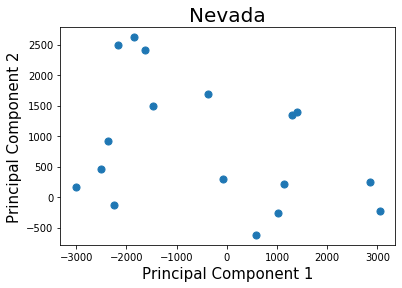

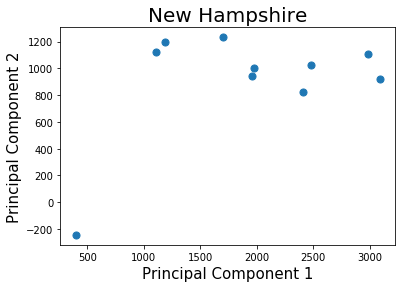

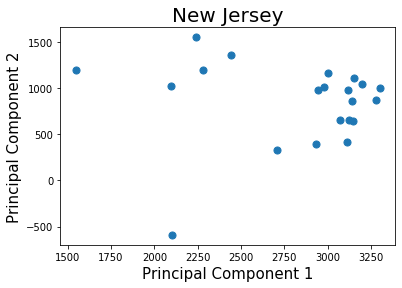

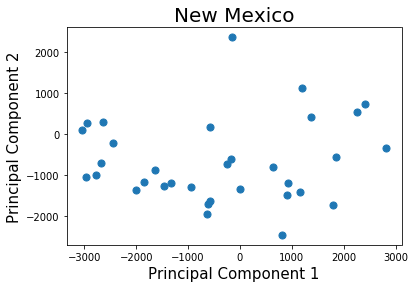

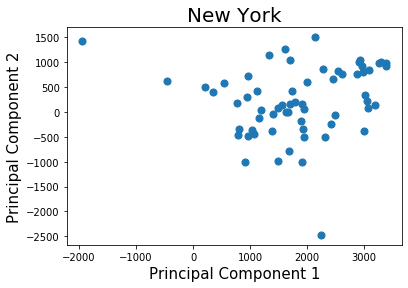

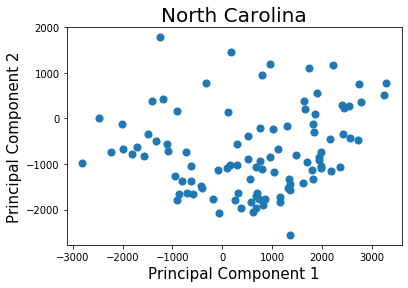

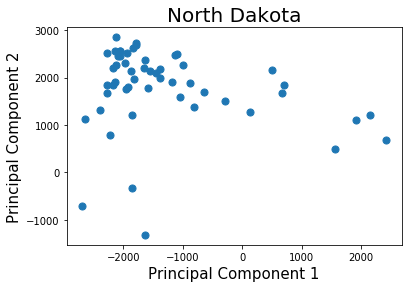

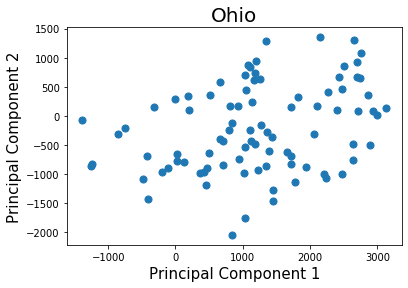

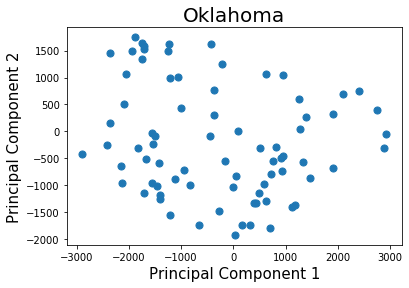

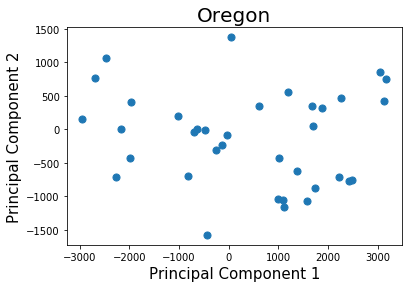

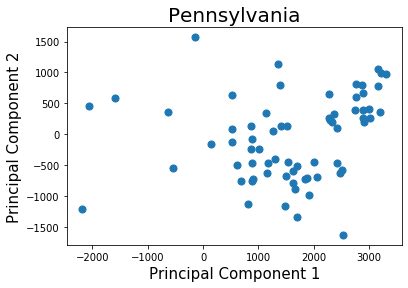

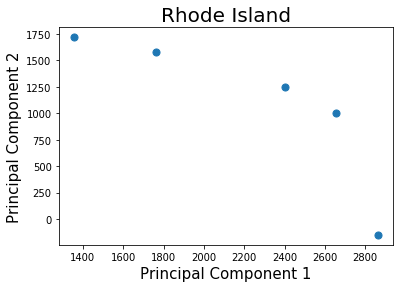

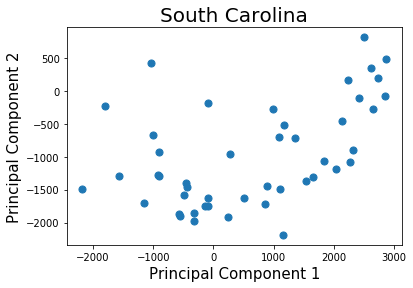

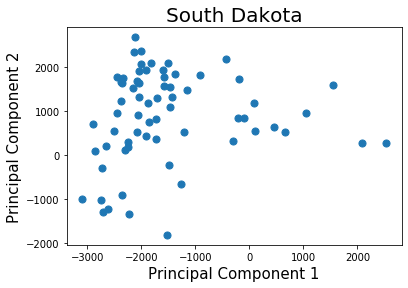

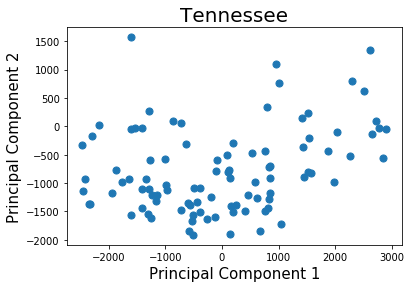

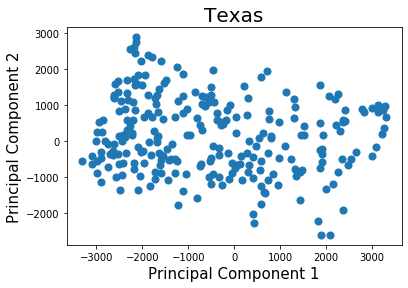

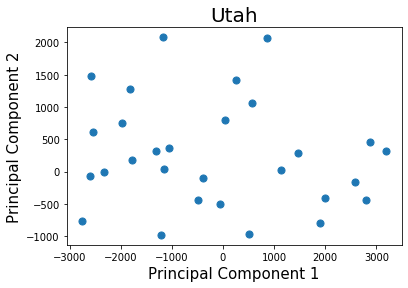

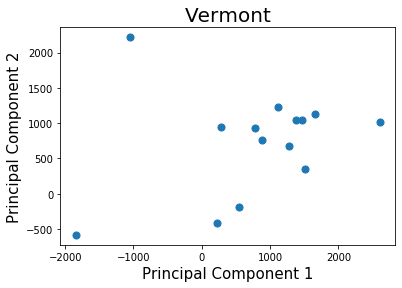

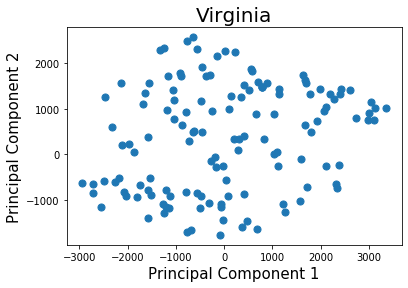

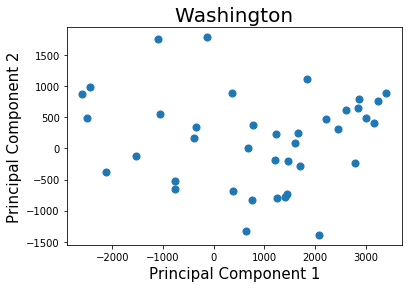

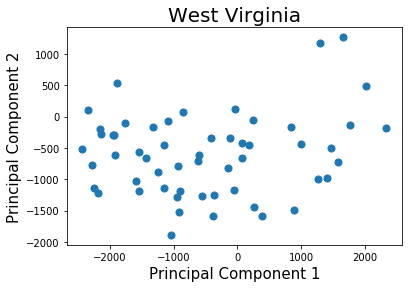

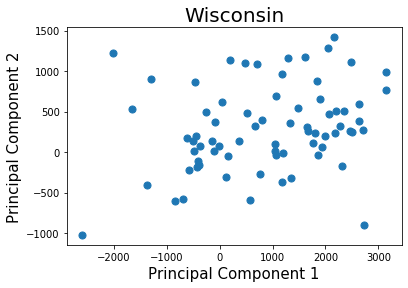

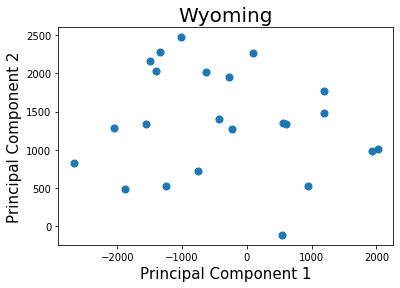

In [15]:
#plotting states 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(base_data[base_data.columns[3:]])

base_data['comp1'] = principalComponents[:,0]
base_data['comp2'] = principalComponents[:,1]


for state in base_data['State'].unique():
    finalDf = base_data[base_data['State'] == state]
    
    plt.xlabel('Principal Component 1', fontsize = 15)
    plt.ylabel('Principal Component 2', fontsize = 15)
    plt.title(state, fontsize = 20)
    plt.scatter(finalDf['comp1'],finalDf['comp2']
               #, c = color
               , s = 50)
    plt.show()
    

# Cosine Similarity

In [21]:
def get_county_from_df(county, state, df):
    return df.query("County=='" + county + "' and State=='" +state+"'")

def get_most_similar_counties(target_embed, test_df, target_name):
    test_df = test_df.dropna()
    test_df[target_name] = test_df['embeddings'].map(lambda x: cosine_similarity(x.reshape(1,-1), target_embed.reshape(1,-1)))
    return test_df.sort_values(by=target_name)

In [17]:
cosine_similarity(get_county_from_df("Aroostook", "Maine", base_data).values[0][2:].reshape(1,-1),
                  get_county_from_df("Broward", "Florida", base_data).values[0][2:].reshape(1,-1))

array([[0.89074348]])

In [18]:
cosine_similarity(get_county_from_df("Aroostook", "Maine", base_data).values[0][2:].reshape(1,-1),
                  get_county_from_df("New York", "New York", base_data).values[0][2:].reshape(1,-1))

array([[0.81590896]])

In [19]:
cosine_similarity(get_county_from_df("Broward", "Florida", base_data).values[0][2:].reshape(1,-1),
                  get_county_from_df("New York", "New York", base_data).values[0][2:].reshape(1,-1))

array([[0.98304729]])

In [23]:
embeddings_df = base_data[['State','County']]
embeddings_df['embeddings'] = [x for x in base_data[base_data.columns[2:]].values]

new_york_ny = get_county_from_df("New York", "New York", embeddings_df).values[0][2:][0]
get_most_similar_counties(new_york_ny, embeddings_df, "new_yor_sim")

,State,County,embeddings,new_yor_sim
2368,South Dakota,Buffalo,"[2.1497106552124023, -0.8239586353302002, -1.8...",[[-0.3285657684984315]]
517,Georgia,Taliaferro,"[1.276008129119873, 1.2426329851150513, 0.0921...",[[-0.32411374606008453]]
1427,Mississippi,Issaquena,"[0.48961248993873596, -1.230534315109253, 1.24...",[[-0.30452713260696296]]
416,Georgia,Clay,"[1.3828041553497314, -0.5580479502677917, -0.3...",[[-0.28897993048144655]]
2407,South Dakota,Mellette,"[1.4614070653915405, 0.5850909352302551, -1.77...",[[-0.28234871920289195]]
...,...,...,...,...
308,Connecticut,Fairfield,"[-0.11895071715116501, -0.36140191555023193, 0...",[[0.9977393066861995]]
1774,New Jersey,Bergen,"[0.6031849980354309, 1.5053329467773438, 2.964...",[[0.997902535797766]]
1886,New York,Westchester,"[1.8554283380508423, -1.0806989669799805, 0.04...",[[0.9984233092153838]]
223,California,San Francisco,"[1.0442835092544556, -2.269986391067505, 1.248...",[[0.9987551304466573]]


In [26]:
ny_similar = get_most_similar_counties(new_york_ny, embeddings_df, "new_yor_sim")

In [29]:
ny_similar.head(20)

,State,County,embeddings,new_yor_sim
2368,South Dakota,Buffalo,"[2.1497106552124023, -0.8239586353302002, -1.8...",[[-0.3285657684984315]]
517,Georgia,Taliaferro,"[1.276008129119873, 1.2426329851150513, 0.0921...",[[-0.32411374606008453]]
1427,Mississippi,Issaquena,"[0.48961248993873596, -1.230534315109253, 1.24...",[[-0.30452713260696296]]
416,Georgia,Clay,"[1.3828041553497314, -0.5580479502677917, -0.3...",[[-0.28897993048144655]]
2407,South Dakota,Mellette,"[1.4614070653915405, 0.5850909352302551, -1.77...",[[-0.28234871920289195]]
566,Idaho,Clark,"[0.9964573979377747, 3.366032361984253, 0.4497...",[[-0.2679270471655668]]
2636,Texas,Hudspeth,"[-2.314197540283203, 0.41246697306632996, -0.9...",[[-0.25601544141608157]]
2426,South Dakota,Ziebach,"[-1.1290327310562134, -0.046180978417396545, -...",[[-0.25459199067849125]]
2375,South Dakota,Corson,"[1.7638647556304932, 2.573261260986328, -0.526...",[[-0.25339340022950235]]
504,Georgia,Quitman,"[2.3790149688720703, 1.7142016887664795, -0.04...",[[-0.25126773725985024]]


In [30]:
ny_similar.tail(20)

,State,County,embeddings,new_yor_sim
246,Colorado,Arapahoe,"[-1.8557631969451904, -1.408712387084961, -0.6...",[[0.9966761674318015]]
1784,New Jersey,Middlesex,"[0.9535868167877197, -1.547747254371643, 0.212...",[[0.9967401902739516]]
1856,New York,Nassau,"[0.0734473168849945, -0.7432646155357361, -1.2...",[[0.9967546166474524]]
2846,Virginia,Fairfax,"[0.4891481399536133, -2.5187735557556152, 0.66...",[[0.9967906561939593]]
1785,New Jersey,Monmouth,"[1.8345919847488403, 2.465914249420166, -0.390...",[[0.9967999517615374]]
1206,Maryland,Montgomery,"[-0.42382940649986267, -0.22574257850646973, -...",[[0.9968848687026359]]
642,Illinois,Lake,"[1.1100966930389404, -1.5930474996566772, -1.3...",[[0.9969325840591707]]
1869,New York,Richmond,"[1.5555875301361084, 1.8749406337738037, -0.47...",[[0.9969713254965045]]
192,California,Contra Costa,"[-0.4897112548351288, 1.2406007051467896, -2.7...",[[0.9969907507295115]]
234,California,Sonoma,"[0.9888178706169128, 0.40945738554000854, -0.7...",[[0.9970049962418244]]


In [32]:
kansas_chase = get_county_from_df("Chase", "Kansas", embeddings_df).values[0][2:][0]
get_most_similar_counties(kansas_chase, embeddings_df, "kansas")

,State,County,embeddings,kansas
1829,New York,Bronx,"[-2.288727045059204, -1.7523223161697388, -0.7...",[[-0.1776897931256175]]
2629,Texas,Hidalgo,"[-2.964916229248047, 0.380361944437027, 1.4307...",[[-0.17659369648907688]]
2592,Texas,El Paso,"[1.3556110858917236, -2.015608787536621, 1.314...",[[-0.1599312815932517]]
2552,Texas,Cameron,"[1.5182641744613647, 0.09614778310060501, -0.6...",[[-0.15766777574477014]]
239,California,Tulare,"[0.7568092346191406, -1.3094981908798218, -0.8...",[[-0.13709264570407156]]
...,...,...,...,...
1271,Michigan,Keweenaw,"[0.8258645534515381, 1.4308985471725464, -0.21...",[[0.9926190557020838]]
1651,Montana,Wibaux,"[0.59537273645401, -0.7259458899497986, -0.441...",[[0.9931215864591119]]
1696,Nebraska,Hitchcock,"[-2.436572790145874, 0.5490058064460754, -0.38...",[[0.9942828095231124]]
896,Kansas,Chautauqua,"[-1.0905488729476929, 0.5197210907936096, 1.95...",[[0.9947042798923242]]


# Results

In [39]:
res_dir = r'C:\Users\Cafral\Desktop\kaggle\team_ts_forecast\embeddings\results\cat2vec\v1'
embeddings_df.to_pickle(res_dir+r'\county_embeddings.csv')

In [40]:
df = pd.read_pickle(res_dir+r'\county_embeddings.csv')

In [41]:
df['embeddings'].loc[0]

array([-1.82603443e+00, -9.60982069e-02, -2.09341437e-01, ...,
        6.78083181e-01,  1.21286551e+03,  3.10218113e+02])

In [42]:
df

,State,County,embeddings
0,Alabama,Autauga,"[-1.826034426689148, -0.09609820693731308, -0...."
1,Alabama,Baldwin,"[1.537409782409668, -2.046318531036377, -0.677..."
2,Alabama,Barbour,"[0.7397575378417969, -0.12028808891773224, -0...."
3,Alabama,Bibb,"[2.0762298107147217, -1.9946370124816895, -1.5..."
4,Alabama,Blount,"[0.868577241897583, -0.25654661655426025, -0.8..."
...,...,...,...
3135,Wyoming,Sweetwater,"[-1.6258422136306763, 3.438875198364258, -0.97..."
3136,Wyoming,Teton,"[0.8812402486801147, -1.9029839038848877, -1.2..."
3137,Wyoming,Uinta,"[0.38998252153396606, 0.7372950315475464, -0.9..."
3138,Wyoming,Washakie,"[1.9899225234985352, 2.6771771907806396, -0.75..."


In [48]:
get_county_from_df("Aroostook", "Maine", df).values[0][2:][0]

array([-5.26232183e-01, -2.53948867e-01, -1.19966602e+00, ...,
        3.22003603e-01,  1.24675143e+03, -1.46145211e+03])

In [50]:
cosine_similarity(get_county_from_df("Aroostook", "Maine", df).values[0][2:][0].reshape(1,-1),
                  get_county_from_df("Broward", "Florida", df).values[0][2:][0].reshape(1,-1))

array([[0.88940555]])

In [52]:
cosine_similarity(get_county_from_df("Aroostook", "Maine", df).values[0][2:][0].reshape(1,-1),
                  get_county_from_df("New York", "New York", df).values[0][2:][0].reshape(1,-1))

array([[0.81479083]])